# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset (not a subset of words or reviews), in this assignment we return to using Turi Create for its efficiency. As usual, let's start by **firing up Turi Create**.

Make sure you have the latest version of Turi Create.

In [1]:
from __future__ import division
import turicreate
import numpy as np

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


# Load amazon review dataset

In [2]:
products = turicreate.SFrame('amazon_baby.sframe/')

# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [3]:
import string

def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words
products['word_count'] = turicreate.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

Now, let's remember what the dataset looks like by taking a quick peek:

In [4]:
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1,'highly': 1, ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1, 'this': 1,'for': 1, 'anyone': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1, 'clever': 1,'approach': 2, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1,'headachesthanks': 1, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'thumb': 1, 'or': 1,'break': 1, 'trying': 1, ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'2995': 1, 'for': 1,'barnes': 1, 'at': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'right': 1, 'because':1, 'questions': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'like': 1, 'and': 1,'changes': 1, 'the': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'in': 1, 'pages': 1,'out': 1, 'run': 1, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'tracker': 1, 'now': 1,'postits': 1, 'stick' ...",1


## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [5]:
train_data, test_data = products.random_split(.8, seed=1)

## Train a logistic regression classifier

We will now train a logistic regression classifier with **sentiment** as the target and **word_count** as the features. We will set `validation_set=None` to make sure everyone gets exactly the same results.  

Remember, even though we now know how to implement logistic regression, we will use Turi Create for its efficiency at processing this Amazon dataset in its entirety.  The focus of this assignment is instead on the topic of precision and recall.

In [6]:
model = turicreate.logistic_classifier.create(train_data, target='sentiment',
                                              features=['word_count'],
                                              validation_set=None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 121712

Number of coefficients      : 121713

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 4        | 0.250000  | 2.077402     | 0.840754          |

| 1         | 9        | 3.250000  | 3.667894     | 0.941514          |

| 2         | 11       | 2.778177  | 4.387198     | 0.942638          |

| 3         | 12       | 2.778177  | 4.841993     | 0.967822          |

| 4         | 13       | 2.778177  | 5.311313     | 0.976495          |

| 5         | 14       | 2.778177  | 5.772960     | 0.976495          |

+-----------+----------+-----------+--------------+-------------------+

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of our trained models using Turi Create, simply pass the option `metric='accuracy'` to the `evaluate` function. We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [7]:
accuracy= model.evaluate(test_data, metric='accuracy')['accuracy']
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9221862251019919


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [8]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


**Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [11]:
confusion_matrix = model.evaluate(test_data, metric='confusion_matrix')['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,-1,896
-1,-1,3543
-1,1,1698
1,1,27199


**Quiz Question**: How many predicted values in the **test set** are **false positives**?

In [ ]:
1698

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [12]:
1698 * 100 + 896

170696

## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [13]:
precision = model.evaluate(test_data, metric='precision')['precision']
print("Precision on test data: %s" % precision)

Precision on test data: 0.941239575042392


**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [14]:
round(1 - 0.941239575042392, 2)

# increase the threshold

0.06

**Quiz Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would (select one):

- Discard a sufficient number of positive predictions
- Discard a sufficient number of negative predictins
- Increase threshold for predicting the positive class ($y_{hat} = +1$)
- Decrease threshold for predicting the positive class ($y_{hat} = +1$)



A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [15]:
recall = model.evaluate(test_data, metric='recall')['recall']
print("Recall on test data: %s" % recall)

Recall on test data: 0.9681082043068162


**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

In [16]:
round(recall, 2)

0.97

In [17]:
#1

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [23]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    return turicreate.SArray([1 if x > threshold else -1 for x in probabilities])

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [24]:
probabilities = model.predict(test_data, output_type='probability')
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [25]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 28897


In [26]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 25031


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

In [27]:
# it falls

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [28]:
# Threshold = 0.5
precision_with_default_threshold = turicreate.evaluation.precision(test_data['sentiment'],
                                        predictions_with_default_threshold)

recall_with_default_threshold = turicreate.evaluation.recall(test_data['sentiment'],
                                        predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = turicreate.evaluation.precision(test_data['sentiment'],
                                        predictions_with_high_threshold)
recall_with_high_threshold = turicreate.evaluation.recall(test_data['sentiment'],
                                        predictions_with_high_threshold)

In [29]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.941239575042392
Recall (threshold = 0.5)   : 0.9681082043068162


In [30]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.9728736366905038
Recall (threshold = 0.9)   : 0.8667734472326036


**Quiz Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Quiz Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [31]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

For each of the values of threshold, we compute the precision and recall scores.

In [32]:
precision_all = []
recall_all = []

probabilities = model.predict(test_data, output_type='probability')
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = turicreate.evaluation.precision(test_data['sentiment'], predictions)
    recall = turicreate.evaluation.recall(test_data['sentiment'], predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

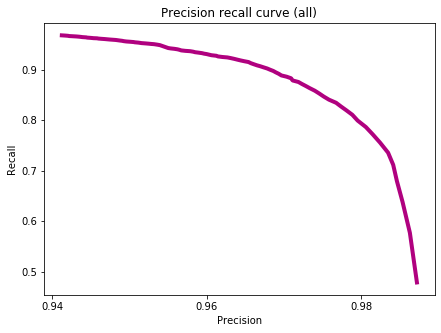

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [41]:
import pandas as pd
df = pd.DataFrame(list(zip(precision_all, recall_all, threshold_values)), columns=['prec', 'rec', 'thr'])

In [44]:
round(0.813131, 3)

0.813

In [43]:
df[df.prec >= 0.965]

,prec,rec,thr
62,0.965419,0.915181,0.813131
63,0.965703,0.913009,0.818182
64,0.966098,0.910838,0.823232
65,0.966529,0.908596,0.828283
66,0.966911,0.906959,0.833333
67,0.967380,0.904609,0.838384
68,0.967822,0.902474,0.843434
69,0.968246,0.899733,0.848485
70,0.968617,0.897526,0.853535
71,0.968935,0.894821,0.858586


In [ ]:
turicreate.evaluation.confusion_matrix()

**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? (**Hint**: You may use the `turicreate.evaluation.confusion_matrix` function implemented in Turi Create.)

In [ ]:
# 9056

In [45]:
probabilities = model.predict(test_data, output_type='probability')
predictions = apply_threshold(probabilities, 0.98)

turicreate.evaluation.confusion_matrix(test_data['sentiment'], predictions)

target_label,predicted_label,count
1,-1,9056
1,1,19039
-1,-1,4943
-1,1,298


This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [46]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive:

In [47]:
probabilities = model.predict(baby_reviews, output_type='probability')

Let's plot the precision-recall curve for the **baby_reviews** dataset.

**First**, let's consider the following `threshold_values` ranging from 0.5 to 1:

In [48]:
threshold_values = np.linspace(0.5, 1, num=100)

**Second**, as we did above, let's compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset.  Complete the code block below.

In [53]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision.
    # YOUR CODE HERE
    
    precision = turicreate.evaluation.precision(baby_reviews['sentiment'], predictions)
    recall = turicreate.evaluation.recall(baby_reviews['sentiment'], predictions)
    
    # YOUR CODE HERE
    #recall = ...
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [54]:
df = pd.DataFrame(list(zip(precision_all, recall_all, threshold_values)), columns=['prec', 'rec', 'thr'])

In [57]:
round(0.848485, 3)

0.848

In [56]:
df[df.prec > 0.965]

,prec,rec,thr
69,0.965192,0.892201,0.848485
70,0.965680,0.890020,0.853535
71,0.965941,0.886748,0.858586
72,0.966607,0.884021,0.863636
73,0.967265,0.880931,0.868687
74,0.967187,0.878749,0.873737
75,0.967852,0.875659,0.878788
76,0.968491,0.871660,0.883838
77,0.968978,0.868751,0.888889
78,0.969375,0.863116,0.893939


**Quiz Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

**Finally**, let's plot the precision recall curve.

In [ ]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")